In [1]:
from scripts import get_data
from models import get_model, get_decoder_layers
import torch
import torch.nn as nn 
import torch.nn.functional as F
from tqdm.notebook import tqdm
from collections import Counter

In [2]:
model, tokenizer = get_model('facebook/opt-125m')
data = get_data(75)
data = data.filter(lambda x: len(x['text']) > 0) 

In [3]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [8]:
@torch.no_grad()
def get_angular_dist(model, data, skip_layers=1): 
    dists = []
    total_tokens = 0
    for x in data:
        tokens = tokenizer(x['text'], return_tensors='pt')
        total_tokens += tokens.input_ids.size(1)
        hidden_states = model(tokens.input_ids.cuda(), output_hidden_states=True).hidden_states 
        # (n_blocks + 1, seq_len, hidden_dim)
        hidden_states = torch.cat(hidden_states, dim=0)
        # (n_blocks - skip_layers + 1, seq_len)
        cos_sim = F.cosine_similarity(hidden_states[:-skip_layers], hidden_states[skip_layers:], dim=-1)
        dist = torch.arccos(cos_sim) / torch.pi

        dists.append(dist.transpose(0, 1).cpu())
    
    return torch.cat(dists, dim=0)

In [9]:
all_losses = get_angular_dist(model, data)
all_losses.shape

torch.Size([9570, 12])

In [10]:
for idx in range(all_losses.size(1)):
    print(idx, all_losses[:, idx].mean())

0 tensor(0.2429)
1 tensor(0.1055)
2 tensor(0.0877)
3 tensor(0.0740)
4 tensor(0.0885)
5 tensor(0.0965)
6 tensor(0.0963)
7 tensor(0.0971)
8 tensor(0.1112)
9 tensor(0.1229)
10 tensor(0.1215)
11 tensor(0.1436)


In [16]:
from collections import Counter
import pandas as pd 
import seaborn as sns 

def plot_topk_distribution(all_losses, k):
    c = Counter(torch.topk(all_losses, k, largest=False).indices.flatten().cpu().numpy())
    df = pd.DataFrame(list(c.items()), columns=['Element', 'Count'])
    sns.barplot(x='Element', y='Count', data=df)

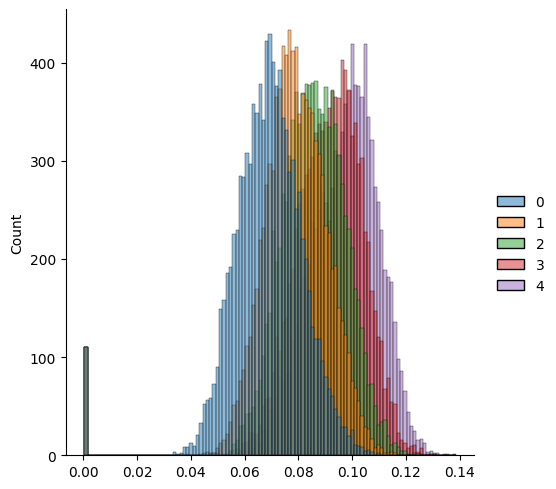

In [17]:
top_3_values = torch.topk(all_losses, 5, largest=False).values
ax = sns.displot(top_3_values.cpu().numpy())

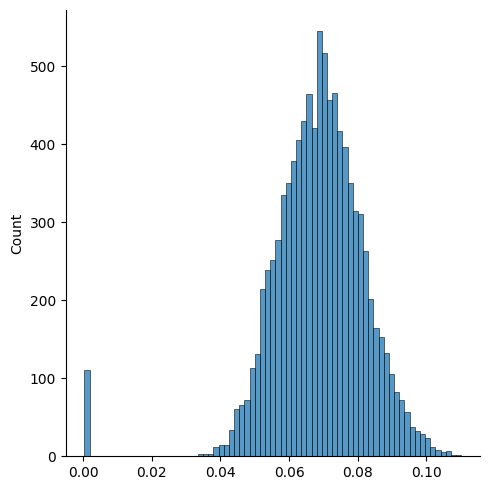

In [18]:
sns.displot(top_3_values[:, 0].cpu().numpy())

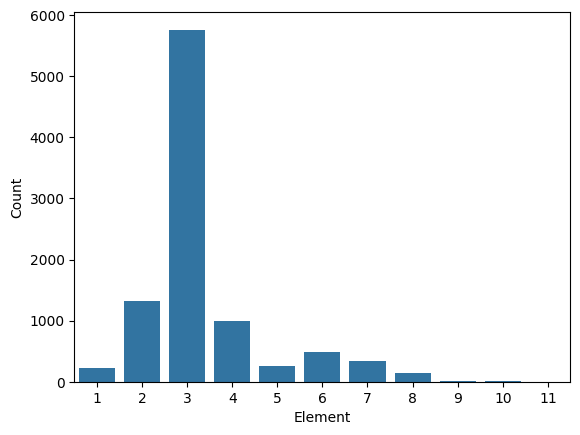

In [19]:
plot_topk_distribution(all_losses, 1)

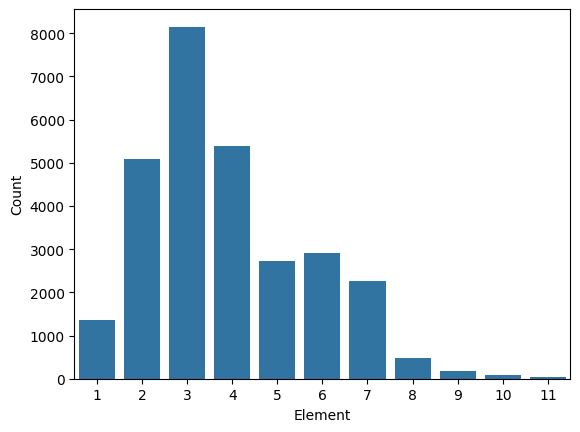

In [20]:
plot_topk_distribution(all_losses, 3)

In [21]:
from tensor_utils import TensorStorage

def collect_output_hooks(model, collect_modules=None, save_uncached=False):
    if collect_modules is None:
        collect_modules = {'block', 'mlp', 'attn'}

    def save_data(module_key: str, save_hidden_states=False, save_output=False, 
                  save_cached=True, save_uncached=False,
                  is_last_module=False):
        def save_data_hook(layer: nn.Module, args, kwargs, output):
            hidden_states = args[0] if len(args) > 0 else kwargs['hidden_states']
            is_first_token = TensorStorage.token_idx == 0
            # if (is_first_token and not save_uncached) or (not is_first_token and not save_cached):
            #     return
            
            save_key = module_key
            if is_first_token:
                save_key += '_first'

            emb = None 
            if save_hidden_states:
                emb = hidden_states
            if save_output: 
                emb = output[0] if isinstance(output, tuple) else output

            TensorStorage.save_embedding(emb, save_key, last_module=is_last_module)

        return save_data_hook

    handles = []
    def reg(module, hook):
        handles.append(module.register_forward_hook(hook, with_kwargs=True))

    layers = get_decoder_layers(model)
    for layer_idx, layer in enumerate(layers):
        if 'block' in collect_modules:
            hook = save_data(f'block{layer_idx}', save_hidden_states=True, save_uncached=save_uncached)
            reg(layer, hook)
            if layer_idx == len(layers) - 1:
                hook = save_data(f'block{layer_idx + 1}', save_output=True, save_uncached=save_uncached, is_last_module=True)
                reg(layer, hook)
        if 'attn' in collect_modules:
            layer_attn_in = layer.temporal_block if hasattr(layer, 'temporal_block') else layer.self_attn 
            layer_attn_out = layer_attn_in
            hook_in = save_data(f'block{layer_idx}_attn_in', save_hidden_states=True, save_uncached=save_uncached)
            hook_out = save_data(f'block{layer_idx}_attn_out', save_output=True, save_uncached=save_uncached)
            reg(layer_attn_in, hook_in)
            reg(layer_attn_out, hook_out)
        if 'mlp' in collect_modules:
            layer_mlp_in, layer_mlp_out = None, None
            if hasattr(layer, 'mlp_block'):
                # RecurrentGemma case 
                layer_mlp_in = layer.mlp_block
                layer_mlp_out = layer_mlp_in
            elif hasattr(layer, 'mlp'):
                # Gated models
                layer_mlp_in = layer.mlp 
                layer_mlp_out = layer_mlp_in
            else:
                # Opt case 
                layer_mlp_in = layer.fc1
                layer_mlp_out = layer.fc2
    
            hook_in  = save_data(f'block{layer_idx}_mlp_in', save_hidden_states=True, save_uncached=save_uncached)
            hook_out = save_data(f'block{layer_idx}_mlp_out', save_output=True, save_uncached=save_uncached)
            reg(layer_mlp_in, hook_in)
            reg(layer_mlp_out, hook_out)

    return handles

In [22]:
@torch.no_grad()
def get_tokens(data, index):
    pref = 0
    result = None 
    assert index >= 0
    for x in data:
        tokens = tokenizer(x['text'], return_tensors='pt')
        n_tokens = tokens.input_ids.size(1)  
        if pref + n_tokens <= index:
            pref += n_tokens
            continue

        # index < pref + n_tokens 
        handles = collect_output_hooks(model, save_uncached=True)
        model(tokens.input_ids.cuda(), use_cache=False)
        
        token_idx = index - pref
        result = {
            # The token is always 0 since only 1 forward pass 
            # Take token 0, squeeze the bsz dimension, then take actual token_idx
            key: TensorStorage._cur_sample[key][0].squeeze(dim=0)[token_idx]
            for key in TensorStorage._cur_sample
            if key.endswith('_first') # This is more of an assert really
        } 
        TensorStorage.reset() 

        for handle in handles:
            handle.remove()
        
        # We found the index 
        break 
    
    return result

In [23]:
for key, item in get_tokens(data, 0).items():
    print(key, item.shape)
    break

block0_attn_in_first torch.Size([768])


In [24]:
for key, item in get_tokens(data, all_losses.size(0) - 1).items():
    print(key, item.shape)
    break

block0_attn_in_first torch.Size([768])


In [25]:
assert get_tokens(data, all_losses.size(0)) is None 

In [26]:
def compute_metric(tokens, key_in, key_out, residual=False, metric='norm_ratio'):
    x_in = tokens[key_in + '_first']
    x_out = tokens[key_out + '_first']
    x_in: torch.Tensor
    if residual:
        x_out = x_out + x_in
    
    if metric == 'norm_ratio':
        return x_out.norm() / x_in.norm()
    elif metric == 'angular_distance':
        return torch.arccos(F.cosine_similarity(x_out, x_in, dim=-1)) / torch.pi
    else:
        assert False

def get_metric(data, indices, key_in, key_out, residual=False, metric='norm_ratio'):
    metrics = torch.zeros_like(indices, dtype=torch.float)
    for i, index in enumerate(indices):
        tokens = get_tokens(data, index)    
        metrics[i] = compute_metric(tokens, key_in, key_out, residual=residual, metric=metric).cpu()

    return metrics.numpy()

def get_metrics_df(data, layer_idx, key_in, key_out, residual=False, metrics=None):
    if metrics is None:
        metrics = ['norm_ratio']

    cutoff = all_losses[:, layer_idx].quantile(0.25)
    good_indices = torch.nonzero(all_losses[:, layer_idx] < cutoff).view(-1)
    bad_indices = torch.nonzero(all_losses[:, layer_idx] >= cutoff).view(-1)[:good_indices.numel()]

    good_values = {metric: None for metric in metrics}
    bad_values = {metric: None for metric in metrics}
    for metric in metrics:
        good_values[metric] = get_metric(data, good_indices, key_in, key_out, residual=residual,metric=metric)
        bad_values[metric] = get_metric(data, bad_indices, key_in, key_out, residual=residual,metric=metric)

    good_df = pd.DataFrame({'category': 'good', **{metric: good_values[metric]}})
    bad_df = pd.DataFrame({'category': 'bad', **{metric: bad_values[metric]}})
    df = pd.concat((good_df, bad_df), ignore_index=True)

    return df 

def plot_nrs_df(df):
    return sns.displot(df, x='norm_ratio', hue='category')

In [17]:
def get_bestk_losses(all_losses, k):
    indices = torch.topk(all_losses, k, largest=False).indices
    list_of_sets = [frozenset(row.tolist()) for row in indices]
    c = Counter(list_of_sets)
    indices_to_remove = c.most_common(1)[0][0]
    orig_layers = get_decoder_layers(model)
    new_layers = nn.ModuleList([layer for idx, layer in enumerate(orig_layers) if idx not in indices_to_remove])
    removed_was_best = torch.tensor([x == indices_to_remove for x in list_of_sets])
    return c, removed_was_best

In [47]:
c, removed_was_best = get_bestk_losses(all_losses, 1)

In [48]:
c.most_common(10)

[(frozenset({3}), 5762),
 (frozenset({2}), 1321),
 (frozenset({4}), 1002),
 (frozenset({6}), 488),
 (frozenset({7}), 341),
 (frozenset({5}), 261),
 (frozenset({1}), 229),
 (frozenset({8}), 149),
 (frozenset({10}), 9),
 (frozenset({9}), 6)]